<a href="https://colab.research.google.com/github/AnyasorG/credit_fraud_risk_prediction/blob/main/credit_card_fraud_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Development of Credit Card Fraud Web app using Machine Learning
Dataset source: https://www.kaggle.com/datasets/rafeulopes/credit-fraud/code

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn tensorflow keras-tuner

In [2]:
%matplotlib inline
# Import necessary libraries

# Initial Imports
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import keras_tuner as kt

In [3]:
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.5.1'
spark_version = 'spark-3.5.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done


In [4]:
!pip install -q kaggle
from google.colab import drive
import shutil
import os

# Mount Google Drive
drive.mount('/content/drive')

# Set paths
kaggle_token_path = '/content/drive/My Drive/kaggle.json'
kaggle_dir = '/root/.kaggle/'

# Check if kaggle directory exists, if not, create it
if not os.path.exists(kaggle_dir):
    os.makedirs(kaggle_dir)

# Copy kaggle.json from Google Drive to appropriate directory
if os.path.exists(kaggle_token_path):
    shutil.copy(kaggle_token_path, kaggle_dir)
    os.chmod(kaggle_dir + 'kaggle.json', 600)

# Download dataset from Kaggle
!kaggle datasets download -d kelvinkelue/credit-card-fraud-prediction

# Unzip the dataset
!unzip -o credit-card-fraud-prediction.zip


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
credit-card-fraud-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  credit-card-fraud-prediction.zip
  inflating: fraud test.csv          


In [5]:
# Initialize Spark session
from pyspark.sql import SparkSession
import os

# Set up Spark session
spark = SparkSession.builder \
    .appName("Kaggle_Dataset") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "2g") \
    .getOrCreate()

# Set the path to the dataset
dataset_path = 'fraud test.csv'  # Assuming the dataset is in the current directory

# Load dataset into Spark DataFrame
df = spark.read.csv(dataset_path, header=True, inferSchema=True)

# Show the first few rows of the DataFrame
df.show()


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


+---+---------------------+----------+--------------------+--------------+------+---------+--------+------+--------------------+-------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+---------+-----------+--------+
|_c0|trans_date_trans_time|    cc_num|            merchant|      category|   amt|    first|    last|gender|              street|         city|state|  zip|    lat|     long|city_pop|                 job|       dob|           trans_num| unix_time|merch_lat| merch_long|is_fraud|
+---+---------------------+----------+--------------------+--------------+------+---------+--------+------+--------------------+-------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+---------+-----------+--------+
|  0|     21/06/2020 12:14|2.29116E15|fraud_Kirlin and ...| personal_care|  2.86|     Jeff| Elliott|     M|   351 Darlene Green|     Columbia|   SC|29209|33.9659| -80.93

In [6]:
# Show schema to confirm date type
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- cc_num: double (nullable = true)
 |-- merchant: string (nullable = true)
 |-- category: string (nullable = true)
 |-- amt: double (nullable = true)
 |-- first: string (nullable = true)
 |-- last: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: string (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- unix_time: integer (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- is_fraud: integer (nullable = true)



In [7]:
# Convert PySpark DataFrame to Pandas DataFrame with correct date formats
df = df.toPandas()

# Convert date columns to correct date format
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], errors='coerce', dayfirst=True)
df['dob'] = pd.to_datetime(df['dob'], errors='coerce', dayfirst=True)

# Remove leading and trailing spaces from all column names
df.columns = df.columns.str.strip()

# Set the option to display all columns
pd.options.display.max_columns = None

# Show the first few rows of the DataFrame
df.head()


,_c0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:00,2.291160e+15,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:00,3.573030e+15,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:00,3.598220e+15,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:00,3.591920e+15,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:00,3.526830e+15,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [8]:
df.columns

Index(['_c0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')

In [9]:
# List of irrelevant column names to drop
columns_to_drop = ['_c0', 'cc_num', 'first', 'last', 'street', 'city', 'state', 'zip', 'job', 'dob', 'trans_num', 'unix_time', 'gender']

# Drop the columns
df = df.drop(columns=columns_to_drop)

# Show the first few rows of the DataFrame
df.head()


,trans_date_trans_time,merchant,category,amt,lat,long,city_pop,merch_lat,merch_long,is_fraud
0,2020-06-21 12:14:00,fraud_Kirlin and Sons,personal_care,2.86,33.9659,-80.9355,333497,33.986391,-81.200714,0
1,2020-06-21 12:14:00,fraud_Sporer-Keebler,personal_care,29.84,40.3207,-110.4360,302,39.450498,-109.960431,0
2,2020-06-21 12:14:00,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,40.6729,-73.5365,34496,40.495810,-74.196111,0
3,2020-06-21 12:15:00,fraud_Haley Group,misc_pos,60.05,28.5697,-80.8191,54767,28.812398,-80.883061,0
4,2020-06-21 12:15:00,fraud_Johnston-Casper,travel,3.19,44.2529,-85.0170,1126,44.959148,-85.884734,0


In [10]:
df.columns


Index(['trans_date_trans_time', 'merchant', 'category', 'amt', 'lat', 'long',
       'city_pop', 'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [11]:
df = df.rename(columns={
    'merchant': 'Merchant',
    'category': 'Transaction Category',
    'amt': 'Transaction Amount',
    'lat': 'Cardholder Latitude',
    'long': 'Cardholder Longitude',
    'city_pop': 'City Population',
    'merch_lat': 'Merchant Latitude',
    'merch_long': 'Merchant Longitude',
    'is_fraud': 'Fraudulent Transaction'
})
df.head()

,trans_date_trans_time,Merchant,Transaction Category,Transaction Amount,Cardholder Latitude,Cardholder Longitude,City Population,Merchant Latitude,Merchant Longitude,Fraudulent Transaction
0,2020-06-21 12:14:00,fraud_Kirlin and Sons,personal_care,2.86,33.9659,-80.9355,333497,33.986391,-81.200714,0
1,2020-06-21 12:14:00,fraud_Sporer-Keebler,personal_care,29.84,40.3207,-110.4360,302,39.450498,-109.960431,0
2,2020-06-21 12:14:00,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,40.6729,-73.5365,34496,40.495810,-74.196111,0
3,2020-06-21 12:15:00,fraud_Haley Group,misc_pos,60.05,28.5697,-80.8191,54767,28.812398,-80.883061,0
4,2020-06-21 12:15:00,fraud_Johnston-Casper,travel,3.19,44.2529,-85.0170,1126,44.959148,-85.884734,0


In [12]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())



Missing values:
trans_date_trans_time     0
Merchant                  0
Transaction Category      0
Transaction Amount        0
Cardholder Latitude       0
Cardholder Longitude      0
City Population           0
Merchant Latitude         0
Merchant Longitude        0
Fraudulent Transaction    0
dtype: int64


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   trans_date_trans_time   555719 non-null  datetime64[ns]
 1   Merchant                555719 non-null  object        
 2   Transaction Category    555719 non-null  object        
 3   Transaction Amount      555719 non-null  float64       
 4   Cardholder Latitude     555719 non-null  float64       
 5   Cardholder Longitude    555719 non-null  float64       
 6   City Population         555719 non-null  int32         
 7   Merchant Latitude       555719 non-null  float64       
 8   Merchant Longitude      555719 non-null  float64       
 9   Fraudulent Transaction  555719 non-null  int32         
dtypes: datetime64[ns](1), float64(5), int32(2), object(2)
memory usage: 38.2+ MB


In [14]:
df.columns

Index(['trans_date_trans_time', 'Merchant', 'Transaction Category',
       'Transaction Amount', 'Cardholder Latitude', 'Cardholder Longitude',
       'City Population', 'Merchant Latitude', 'Merchant Longitude',
       'Fraudulent Transaction'],
      dtype='object')

In [15]:
# Generate summary statistics for numerical columns
df.describe().round()

,trans_date_trans_time,Transaction Amount,Cardholder Latitude,Cardholder Longitude,City Population,Merchant Latitude,Merchant Longitude,Fraudulent Transaction
count,555719,555719.0,555719.0,555719.0,555719.0,555719.0,555719.0,555719.0
mean,2020-10-02 01:53:55.673389056,69.0,39.0,-90.0,88222.0,39.0,-90.0,0.0
min,2020-06-21 12:14:00,1.0,20.0,-166.0,23.0,19.0,-167.0,0.0
25%,2020-08-09 06:10:00,10.0,35.0,-97.0,741.0,35.0,-97.0,0.0
50%,2020-10-03 00:59:00,47.0,39.0,-87.0,2408.0,39.0,-87.0,0.0
75%,2020-12-01 03:02:30,83.0,42.0,-80.0,19685.0,42.0,-80.0,0.0
max,2020-12-31 23:59:00,22768.0,66.0,-68.0,2906700.0,67.0,-67.0,1.0
std,NaN,157.0,5.0,14.0,300391.0,5.0,14.0,0.0


Compute Correlation Matrix

In [16]:
# Select only numerical columns for correlation calculation
numerical_columns = df.select_dtypes(include=['float64', 'int32']).columns

# Compute correlation matrix
correlation_matrix = df[numerical_columns].corr()

# Print the correlation matrix
correlation_matrix.round(2)


,Transaction Amount,Cardholder Latitude,Cardholder Longitude,City Population,Merchant Latitude,Merchant Longitude,Fraudulent Transaction
Transaction Amount,1.00,0.00,-0.00,0.00,0.00,-0.00,0.18
Cardholder Latitude,0.00,1.00,-0.01,-0.15,0.99,-0.01,0.01
Cardholder Longitude,-0.00,-0.01,1.00,-0.05,-0.01,1.00,-0.00
City Population,0.00,-0.15,-0.05,1.00,-0.15,-0.05,-0.00
Merchant Latitude,0.00,0.99,-0.01,-0.15,1.00,-0.01,0.01
Merchant Longitude,-0.00,-0.01,1.00,-0.05,-0.01,1.00,-0.00
Fraudulent Transaction,0.18,0.01,-0.00,-0.00,0.01,-0.00,1.00


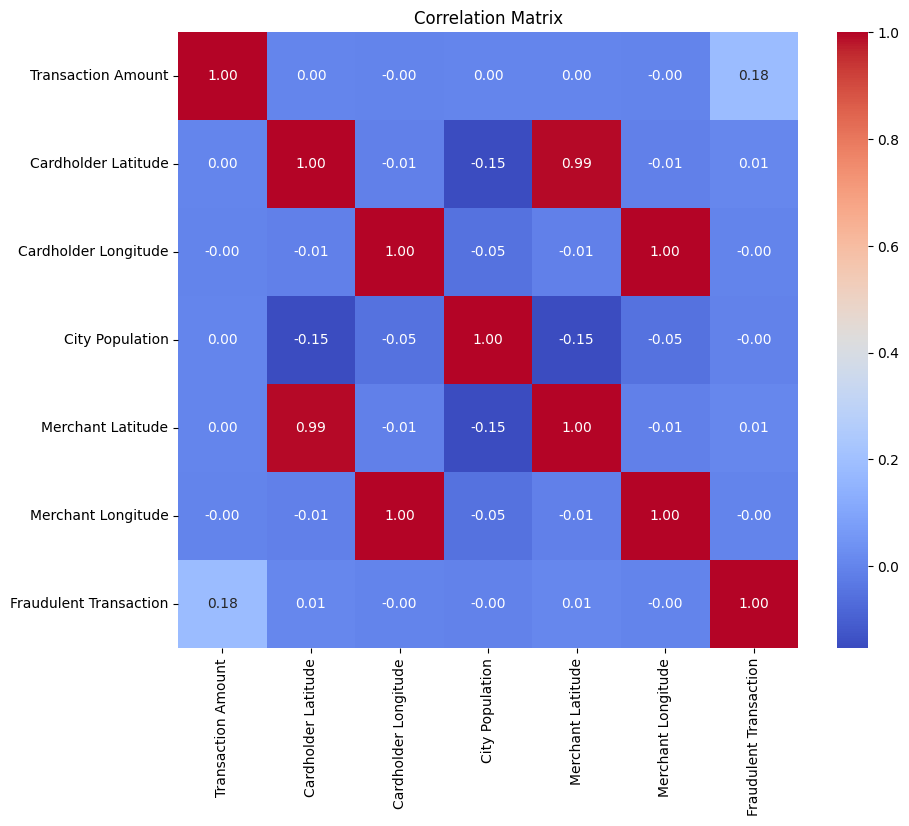

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numerical columns for correlation calculation
numerical_columns = df.select_dtypes(include=['float64', 'int32']).columns

# Compute correlation matrix
correlation_matrix = df[numerical_columns].corr()

# Create a heatmap plot
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [18]:
# Check the data types of all columns
print(df.dtypes)


trans_date_trans_time     datetime64[ns]
Merchant                          object
Transaction Category              object
Transaction Amount               float64
Cardholder Latitude              float64
Cardholder Longitude             float64
City Population                    int32
Merchant Latitude                float64
Merchant Longitude               float64
Fraudulent Transaction             int32
dtype: object


In [19]:
df.head()

,trans_date_trans_time,Merchant,Transaction Category,Transaction Amount,Cardholder Latitude,Cardholder Longitude,City Population,Merchant Latitude,Merchant Longitude,Fraudulent Transaction
0,2020-06-21 12:14:00,fraud_Kirlin and Sons,personal_care,2.86,33.9659,-80.9355,333497,33.986391,-81.200714,0
1,2020-06-21 12:14:00,fraud_Sporer-Keebler,personal_care,29.84,40.3207,-110.4360,302,39.450498,-109.960431,0
2,2020-06-21 12:14:00,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,40.6729,-73.5365,34496,40.495810,-74.196111,0
3,2020-06-21 12:15:00,fraud_Haley Group,misc_pos,60.05,28.5697,-80.8191,54767,28.812398,-80.883061,0
4,2020-06-21 12:15:00,fraud_Johnston-Casper,travel,3.19,44.2529,-85.0170,1126,44.959148,-85.884734,0


In [20]:
# Create a dictionary to map each unique Transaction Category to a numerical code
category_map = {
    'entertainment': 0,
    'food_dining': 1,
    'gas_transport': 2,
    'grocery_net': 3,
    'grocery_pos': 4,
    'health_fitness': 5,
    'home': 6,
    'kids_pets': 7,
    'misc_net': 8,
    'misc_pos': 9,
    'personal_care': 10,
    'shopping_net': 11,
    'shopping_pos': 12,
    'travel': 13,
}

# Map the Transaction Category column using the dictionary
df['Transaction Category'] = df['Transaction Category'].map(category_map)

# Display the DataFrame with mapped Transaction Category values
df.head()


,trans_date_trans_time,Merchant,Transaction Category,Transaction Amount,Cardholder Latitude,Cardholder Longitude,City Population,Merchant Latitude,Merchant Longitude,Fraudulent Transaction
0,2020-06-21 12:14:00,fraud_Kirlin and Sons,10,2.86,33.9659,-80.9355,333497,33.986391,-81.200714,0
1,2020-06-21 12:14:00,fraud_Sporer-Keebler,10,29.84,40.3207,-110.4360,302,39.450498,-109.960431,0
2,2020-06-21 12:14:00,"fraud_Swaniawski, Nitzsche and Welch",5,41.28,40.6729,-73.5365,34496,40.495810,-74.196111,0
3,2020-06-21 12:15:00,fraud_Haley Group,9,60.05,28.5697,-80.8191,54767,28.812398,-80.883061,0
4,2020-06-21 12:15:00,fraud_Johnston-Casper,13,3.19,44.2529,-85.0170,1126,44.959148,-85.884734,0


In [21]:
# Identify unique values in the 'Merchant' column
unique_merchants = df['Merchant'].nunique()

# Display unique values
print(unique_merchants)


693


In [22]:
# Strip leading and trailing whitespace from the 'Merchant' column
df['Merchant'] = df['Merchant'].str.strip()

# Use factorize to map unique Merchant values to numerical codes
df['Merchant'] = pd.factorize(df['Merchant'])[0]

# Display the DataFrame with mapped Merchant values
df.head()


,trans_date_trans_time,Merchant,Transaction Category,Transaction Amount,Cardholder Latitude,Cardholder Longitude,City Population,Merchant Latitude,Merchant Longitude,Fraudulent Transaction
0,2020-06-21 12:14:00,0,10,2.86,33.9659,-80.9355,333497,33.986391,-81.200714,0
1,2020-06-21 12:14:00,1,10,29.84,40.3207,-110.4360,302,39.450498,-109.960431,0
2,2020-06-21 12:14:00,2,5,41.28,40.6729,-73.5365,34496,40.495810,-74.196111,0
3,2020-06-21 12:15:00,3,9,60.05,28.5697,-80.8191,54767,28.812398,-80.883061,0
4,2020-06-21 12:15:00,4,13,3.19,44.2529,-85.0170,1126,44.959148,-85.884734,0
